# Using the model to cluster songs according to their genre

In [51]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
import csv
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA

In [52]:
#Helper functions
def createGenreMap():
    genreMap = {} #key:track id, value:genre

    # Open the CSV file in read mode, NOTE: You have to have the file labels.csv in your directory, its available in drive
    with open('labels.csv', 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        #Skip first row (header row)
        next(csv_reader)
    
        # Iterate through the rows in the CSV file
        for row in csv_reader:
            raw_number = int(row[0])
            track_id = f"{raw_number:06d}"
            genre = row[1]
            genreMap[track_id] = genre

    return genreMap
    
def getLabel(genreMap, track_id):
    #Genre map is dictionary created above, track_id is string id of track.
    return genreMap[track_id]

In [53]:
"""METHOD 1: UMAP"""

def umap_clustering(data, reduced_dim, genre_labels):
    """Parameters:
       data: All latent space representations of the tracks, assumes shape (number of tracks, latent_dim)
       reduced_dim: reduced dimension, 2 or 3 for visualization
       num_classes: number of classes i.e the number of genres
       genre_labels: list of genre names corresponding to each track
    """
    #Encode the genres to integers (umap works with integer classes)
    le = LabelEncoder()
    numeric_labels = le.fit_transform(genre_labels)

    reducer = umap.UMAP(n_components=reduced_dim) #reduces the dimension
    reduced_proj = reducer.fit_transform(data) #Projection of reduced dimension

    #Plot
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(reduced_proj[:, 0], reduced_proj[:, 1], c=numeric_labels, cmap='tab20')

    #Get genre names from integers for plot
    unique_labels = np.unique(numeric_labels)
    genre_names = le.inverse_transform(unique_labels)
    colors = plt.cm.tab20(np.linspace(0, 1, 20))


    patches = [mpatches.Patch(color=colors[i],label=name)
               for i, name in zip(unique_labels, genre_names)]
    
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Genres")

    plt.title("UMAP clustering")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()

In [ ]:
"""METHOD 2: PCA"""

def pca_clustering(data, reduced_dim, genre_labels):
    """
    Parameters:
        data: Latent representations of tracks, shape (n_tracks, latent_dim)
        reduced_dim: 2 or 3
        genre_labels: List of genre names (strings)
    """
    le = LabelEncoder()
    numeric_labels = le.fit_transform(genre_labels)

    # PCA transformation
    pca = PCA(n_components=reduced_dim)
    reduced_proj = pca.fit_transform(data)

    # Colors
    colors = plt.cm.tab20(np.linspace(0, 1, 20))

    # Plot
    fig = plt.figure(figsize=(10, 7))

    if reduced_dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(reduced_proj[:, 0], reduced_proj[:, 1], reduced_proj[:, 2],
                             c=numeric_labels, cmap='tab20')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
    elif reduced_dim ==2:
        scatter = plt.scatter(reduced_proj[:, 0], reduced_proj[:, 1],
                              c=numeric_labels, cmap='tab20')
        plt.xlabel("x")
        plt.ylabel("y")
    else:
        print('Please make the reduced_dim 2 or 3')
        return

    # Legend with genre names
    unique_labels = np.unique(numeric_labels)
    genre_names = le.inverse_transform(unique_labels)
    patches = [mpatches.Patch(color=colors[i], label=name)
               for i, name in zip(unique_labels, genre_names)]

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Genres")
    plt.title("PCA Clustering")
    plt.tight_layout()
    plt.show()

In [55]:
mapping = createGenreMap()

In [56]:
#Get data
track_ids = mapping.keys()
print(f"Track names: {list(track_ids)}")

genre_labels = list(mapping.values())
print(f"Genre corresponding to each track: {genre_labels}")

number_of_tracks = len(track_ids)
genres = set(genre_labels)
num_of_genres = len(genres)

print(f"Number of tracks: {number_of_tracks}")
print(f"Genres: {genres}")
print(f"Number of genres: {num_of_genres}")

Track names: ['000002', '000003', '000005', '000010', '000020', '000026', '000030', '000046', '000048', '000134', '000135', '000136', '000137', '000138', '000139', '000140', '000141', '000142', '000144', '000145', '000146', '000147', '000148', '000149', '000150', '000151', '000152', '000153', '000154', '000155', '000156', '000157', '000158', '000159', '000160', '000161', '000162', '000163', '000164', '000165', '000166', '000167', '000168', '000169', '000170', '000171', '000172', '000173', '000174', '000175', '000176', '000177', '000178', '000179', '000181', '000182', '000183', '000184', '000185', '000188', '000189', '000190', '000191', '000192', '000193', '000194', '000195', '000196', '000197', '000198', '000199', '000200', '000201', '000202', '000203', '000204', '000205', '000206', '000207', '000208', '000209', '000210', '000211', '000212', '000213', '000226', '000228', '000236', '000237', '000238', '000246', '000247', '000248', '000249', '000250', '000251', '000252', '000253', '00025

c:\Users\Lukas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


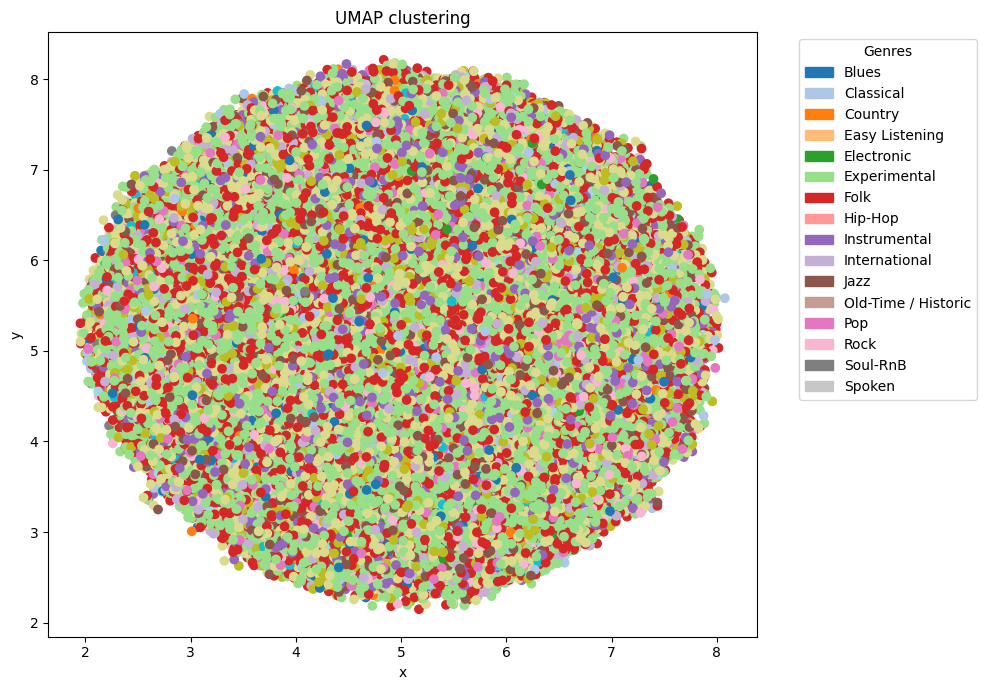

In [57]:
#Example usage of umap
latent_dim = 20
reduced_dim = 2
dummy_data = np.random.randn(number_of_tracks, latent_dim) #Random 20-dimensional latent space representation of each track

umap_clustering(dummy_data, reduced_dim, genre_labels)

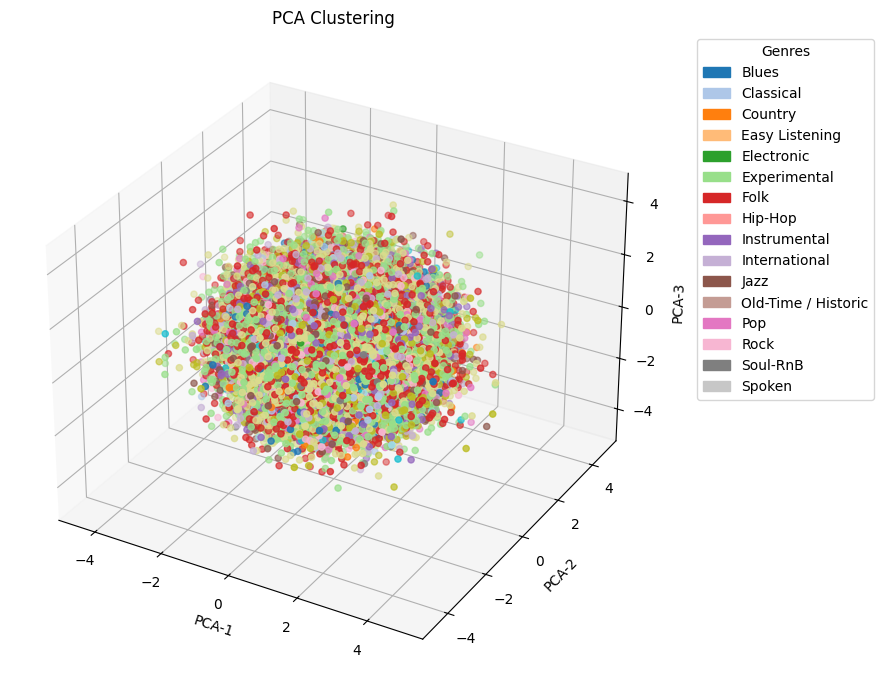

In [60]:
#Example usage of pca

latent_dim = 20
reduced_dim = 3
dummy_data = np.random.randn(number_of_tracks, latent_dim) #Random 20-dimensional latent space representation of each track

pca_clustering(dummy_data, reduced_dim, genre_labels)

In [63]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plots
from sklearn.preprocessing import LabelEncoder
import numpy as np

def umap_clustering_3d(data, reduced_dim, genre_labels):
    """
    Parameters:
        data: All latent space representations of the tracks, shape (n_tracks, latent_dim)
        reduced_dim: Reduced dimension for UMAP (2 or 3)
        genre_labels: List of genre names corresponding to each track
    """
    le = LabelEncoder()
    numeric_labels = le.fit_transform(genre_labels)

    reducer = umap.UMAP(n_components=reduced_dim)
    reduced_proj = reducer.fit_transform(data)

    colors = plt.cm.tab20(np.linspace(0, 1, 20))

    fig = plt.figure(figsize=(10, 7))

    if reduced_dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(reduced_proj[:, 0], reduced_proj[:, 1], reduced_proj[:, 2],
                             c=numeric_labels, cmap='tab20')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
    elif reduced_dim == 2:
        scatter = plt.scatter(reduced_proj[:, 0], reduced_proj[:, 1],
                              c=numeric_labels, cmap='tab20')
        plt.xlabel("x")
        plt.ylabel("y")
    else:
        print("Please enter 2 or 3 and the reduced_dim")
        return

    # Legend
    unique_labels = np.unique(numeric_labels)
    genre_names = le.inverse_transform(unique_labels)
    patches = [mpatches.Patch(color=colors[i], label=name)
               for i, name in zip(unique_labels, genre_names)]

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Genres")
    plt.title("UMAP Clustering")
    plt.tight_layout()
    plt.show()


c:\Users\Lukas\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


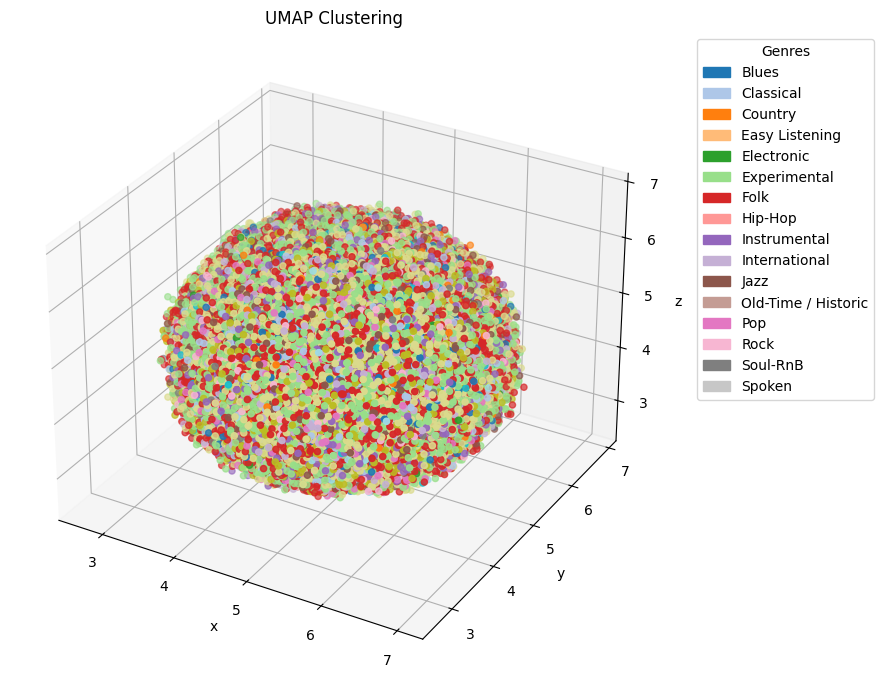

In [66]:
umap_clustering_3d(dummy_data, 3, genre_labels)